In [1]:
import numpy as np
import pandas as pd

from fractions import Fraction
from collections import defaultdict, Counter
from iteration_utilities import deepflatten #flatten nested lists
import matplotlib.pyplot as plt

from music21 import midi, note, interval, pitch, serial, stream, instrument, meter, key, converter, scale, graph
import itertools
import random


import nltk #for NLP
import string
import mchmm #for Markov models

# Helpers

In [2]:
def play(stream):
    """Shortcut to play a stream"""
    midi.realtime.StreamPlayer(stream).play()
    
def get_stream(pitches, **kwargs):
    """Turns a collection of pitches into a Stream."""
    st = stream.Stream(**kwargs)
    if isinstance(pitches[0], pitch.Pitch):
        for p in pitches:
            st.append(note.Note(p))
    else:
        for p in pitches:
            st.append(p)
    return st

def get_measure(pitches, dur=1, **kwargs):
    """Turns a collection of pitches into a stream.Measure"""
    st = stream.Measure(**kwargs)
    if isinstance(pitches[0], pitch.Pitch):
        for p in pitches:
            st.append(note.Note(p, quarterLength=dur))
    else:
        for p in pitches:
            st.append(p)
    return st

def get_notes(pitches, **kwargs):
    """Convert a collection of pitches into a list of Notes"""
    return [note.Note(p, **kwargs) for p in pitches]


In many musical cultures, the organisation of pitch is based on the selection of an alphabet of pitch material. In most of the Western classical tradition, the largest alphabet is formed by the *chromatic* collection, comprising a subdivision of the octave in 12 chromatic steps, the *semitones*. 

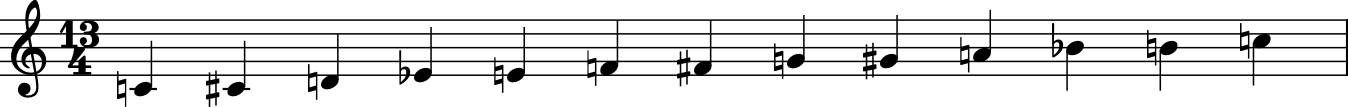

In [3]:
CHROMATIC = range(60, 60+13)
m = stream.Measure()
m.append([note.Note(pitch = x) for x in CHROMATIC])
m.show()

Intervals among pitches are computed by counting the number of 'steps' that separate them.

# Series

A specific ordering of the 12 chromatic tones, a series, can be used as the building material for a composition, as proposed in the serialist twelve-tone technique. If we look at the incipit of Pierre Boulez' [*Structures 1a*](https://www.youtube.com/watch?v=EmErwN02fX0), we can observe that each one of the two pianos plays sequentially all 12 tones from the chromatic set. 

<img src="boulez.png">

First, let's focus on the Piano I part. The pitch material is the following:

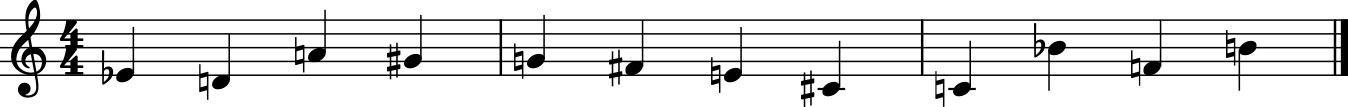

In [4]:
sb = serial.ToneRow([3, 2, 9, 8, 7, 6, 4, 1, 0, 10, 5, 11])
sb.show()

This is the series, or twelve-tone row, upon which the composition of the whole piece is based. Each segment of the piece comprises a cycle of the twelve-tone row or of a transformation thereof. For example, the notes played by the Piano II are obtained by inverting all intervals in the original row:

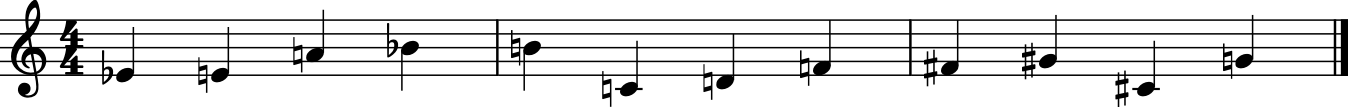

In [5]:
sb.originalCenteredTransformation('I',0).show()

Beyond inversion, other possible transformations of a twelve-tone row include the retrograde (i.e., playing the row backwards):

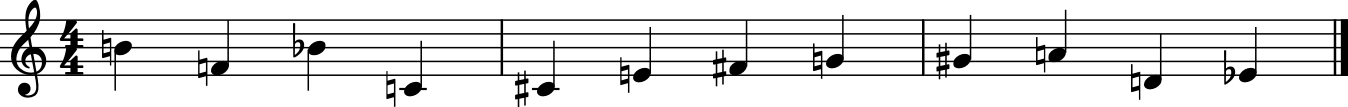

In [6]:
sb.originalCenteredTransformation('R',0).show()

and the retrograde inversion (i.e., playing the inversion of the original backwards):

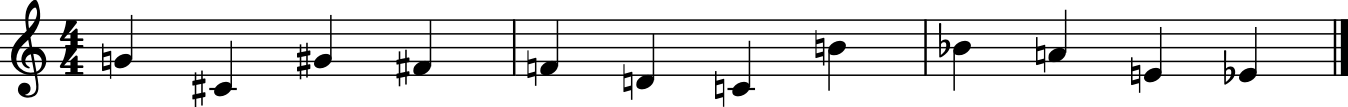

In [7]:
sb.originalCenteredTransformation('RI',0).show()

A row can also be transposed to start from a different note: here, for example, is the retrograde inverted form of the original row transposed 3 semitones up

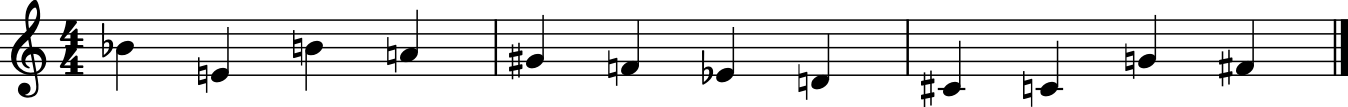

In [8]:
sb.originalCenteredTransformation('RI',3).show()

In *Structures*, pitch is not the only parameter of the music to be treated serially: the possible values of duration, intensity and articulation are also organised in rows, and the piece systematically cycles through the rows for each parameter. This technique is called *integral serialism*. Here are the rows for pitch, duration, intensity and articulation [(Lombardi & Wester, 2008)](https://www.jstor.org/stable/10.1525/mts.2008.30.2.339):

<img src="boulezseries.png">

With *Structures*, Boulez wanted to *eradicate from my vocabulary absolutely every trace of the conventional, whether it concerned figures and phrases, or development and form; I then wanted gradually, element after element, to win back the various stages of the compositional process, in such a manner that a perfectly new synthesis might arise, a synthesis that would not be corrupted from the very outset by foreign bodies – stylistic reminiscences in particular* (Boulez, 1986). The integral serialist approach was the first step of this attempt to develop an "unbiased" compositional process.

# Pitch class and Pitch-class sets

Starting from the chromatic collection, other pitch collections can be formed as subsets of the chromatic one. Note that octave equivalence induces a partition of the chromatic collection (which, in principle, extends indefinitely to the right and to the left), into 12 distinct pitch-classes. E.g.:

In [9]:
note.Note("F8").pitch.pitchClass == note.Note("F4").pitch.pitchClass

True

The interval between two pitch classes is not well-defined: for example, if we consider pitch-classes C and G#, we can have the G# lying 8 semitones above the C...

In [10]:
C = note.Note('C4')
highGis = note.Note('G#4')
ChighGis = interval.Interval(noteStart = C, noteEnd = highGis)
ChighGis.semitones

8

or the one 4 semitones below the C:

In [11]:
lowGis = note.Note('G#3')
lowGisC = interval.Interval(noteStart = lowGis, noteEnd = C)
lowGisC.semitones

4

We define instead the interval class between two pitch classes as the smallest interval between representatives of the two classes:

In [12]:
n1 = note.Note('C')
n2 = note.Note('G#')
n1n2 = interval.Interval(noteStart = n1, noteEnd = n2)
n1n2.intervalClass

4

Pitch-class sets are unordered collections of pitch classes. Each pitch class in a pitch-class set may be identified by a number from 0 to 11, 0 corresponding to the pitch class of a C. 

In [13]:
pitchClassSet = {0, 3, 5}

def notes_from_pitchClassSet(pitchClassSet, transpose = 0):
    """Returns list of notes based on a pitchClassSet and a transposition (default, start on C)"""
    return [note.Note(pitch = pitchClass+transpose) for pitchClass in pitchClassSet]

pitchClassSetNotes = notes_from_pitchClassSet(pitchClassSet)
pitchClassSetNotes

[<music21.note.Note C>, <music21.note.Note E->, <music21.note.Note F>]

In order to characterize a pitch class set, we can look at the intervals formed by the members of the set. In particular, we consider all possible interval classes between any two members of the set. The interval vector of a pitch class is a 6-vector whose i-th component reflects how many interval classes of size i are to be found among all the possible pairings of elements of the set.

In [14]:
def intervalVector(notes):
    """Compute the interval vector of a list of notes"""
    vector = {i+1:0 for i in range(6)}
    pairs = itertools.combinations(notes, 2)
    for pair in pairs:
        intClass = interval.Interval(pair[0], pair[1]).intervalClass
        vector[intClass] += 1
    return vector

intervalVector(pitchClassSetNotes)

{1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 0}

Interval vectors capture an important aspect of the compositional possibilities that arise when adopting a certain pitch-class set as the pitch alphabet for a piece (or a portion thereof): they tell us what are the possible intervals that can be formed if those pitches are played one after the other (melodically) or simultaneously (harmonically).

Algebraic properties of pitch-class sets, such as their invariances under transformations, are a fertile terrain for creative and algorithmic exploration. If you are interested, you can read more on musical set theory, e.g. starting from this simple introduction https://musictheory.pugetsound.edu/mt21c/SetTheory.html.

In [15]:
def select_from_chromatic(intervals, root = 'C'):
    """Selects pitches from a chromatic collection based on a set of intervals"""
    return [note.Note(pitch = pitch.Pitch(root).midi + x) for x in [0]+[sum(intervals[:i+1]) for i in range(len(intervals))]]

# Scales and modes

A very commong ordered subcollection of the chromatic collection in Western classical music is the major scale, that we can identify by indicating the intervals in semitones between consecutive tones:

pygame 2.0.0 (SDL 2.0.12, python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


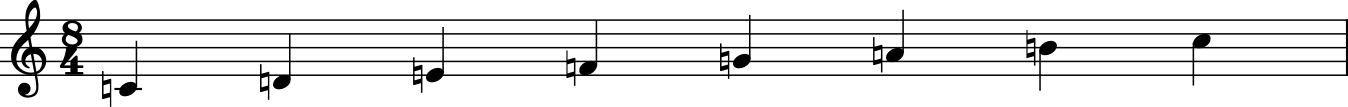

In [16]:
MAJOR = [2, 2, 1, 2, 2, 2, 1]
m = stream.Measure()
m.append(select_from_chromatic(MAJOR))
play(m)
m.show()

Note that the intervals in a major scale are not all the same: between the third and the fourth note, as well as between the seventh and the eigth (which is equivalent to the first under octave equivalence) there is an interval of just 1 semitone. 

We can obtain other *modes* that are based on the same selection of itnervals by rotating the list of intervals, and changing the root.

In [17]:
def rotate_list(l, n):
    """rotate list l by n steps"""
    return l[n:] + l[:n]

def select_mode(mode, root, scale = MAJOR):
    """select a mode based on a root"""
    return select_from_chromatic(rotate_list(scale, mode), root)

<img src="EcclesiasticalModes.png">

For example, here is the so-called "phrygian" mode, which shares all pitches with the major scale, but with a different ordering of intervals (starting from root E):

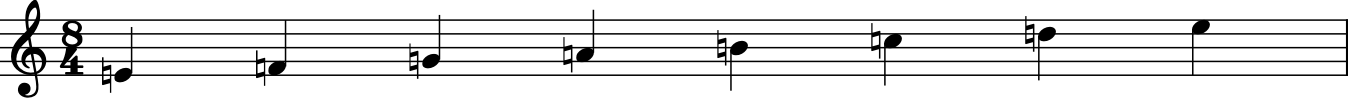

In [18]:
phrygian = select_mode(2, 'E')
m = stream.Measure()
m.append(phrygian)
play(m)
m.show()

The chromatic subdivision of the octave in 12 semitones is particularly relevant in the Western classical tradition. However, different cultures draw their pitch materials from different scales, whose pitches do not correspond to any of the chromatic tones. Here are two examples from the Javanese tradition, the *pelog* and the *slendro* scale. Note that, while the *pelog* scale results in an unequal subdivision of the octave (similarly to the Western diatonic scale), the *slendro* scale divides the octave in roughly equal intervals. 

<img src="scales.png">

<video controls src="gamelan.mp4" />

# Dividing the octave

Selecting pitch materials is part of the compositional process, and you can be creative in how to extract pitches from the continuum of pitch space! Here is an example of a scale generated by a fractal division of the octave with recursive golden-ratio splits;

In [19]:
def fractal_division(ratio, smallest, interval = 1, displace = 0):
    """Recursively divide an interval based on a given ratio, up to a threshold (smallest). Returns list of split points."""
    split = [interval * ratio, interval * (1-ratio)]
    
    if min(split) >= smallest:
        
        splits = []
        
        onset = displace
        for i in split:
            splits += fractal_division(ratio, smallest, interval = i, displace = onset)
            onset += i
        
        return splits
        
    else:
        return [interval+displace]

In [20]:
def scale_from_division(division, span,  root):
    """Returns scale (from root to span) from a list of split points"""
    new_scale = [pitch.Pitch(root)] + [pitch.Pitch() for _ in division]
    for i in range(len(division)):
        new_scale[i+1].ps = root + division[i] * span
    return new_scale

In [21]:
golden = 2/(1 + 5 ** 0.5)
golden_division = fractal_division(golden, 1/12)
m = get_measure(scale_from_division(golden_division, 12, 60))
play(m)

# Melody generation
## Random

In [22]:
sc = scale.ConcreteScale(pitches=scale_from_division(golden_division, 12, 60))
pitch_collection = sc.getPitches('C1', 'C5')
print(f"pitch_collection contains {len(pitch_collection)} pitches.")

pitch_collection contains 33 pitches.


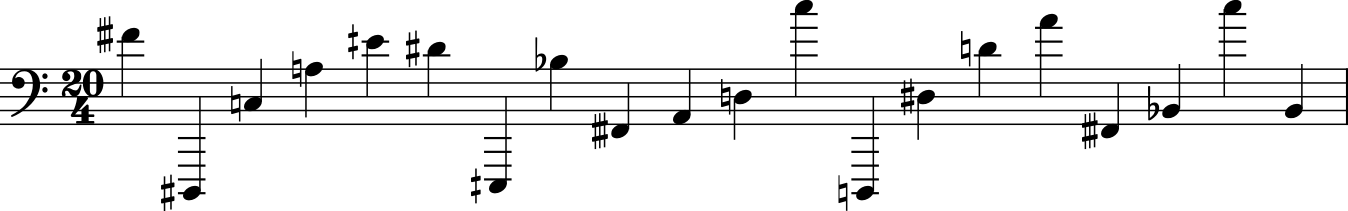

In [23]:
random_melody = random.choices(pitch_collection, k=20)
get_measure(random_melody).show()

In [26]:
def random_duration():
    """Generator yielding infinitely many random fractions."""
    base = (1, 2, 3, 4, 5)
    while True:
        numerator, denominator = random.choices(base, k=2)
        yield numerator/denominator
    
duration_generator = random_duration()
next(duration_generator)

3.0

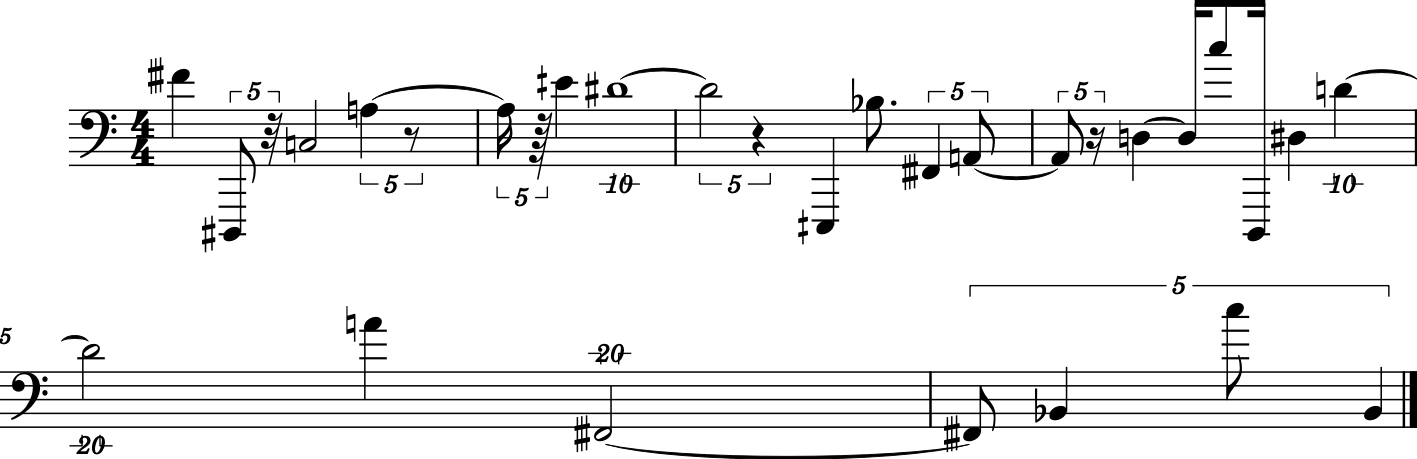

In [27]:
notes = [note.Note(pitch=p, quarterLength=d) for p, d in zip(random_melody, random_duration())]
melody = get_stream(notes)
melody.show()
play(melody)

## Recursive approach (based on the Grammar idea)

In [28]:
SCALE = scale.MinorScale('a')
LARGE_SKIP = 9


class pair:
    
    scale = SCALE
    
    def __init__(self, left, right=None):
        if right is None:
            right = left
        self.l, self.r = left, right
        self.apply_rule()
        
    def apply_rule(self):
        if isinstance(self.l, pitch.Pitch):
            if self.l == self.r:
                self.large_skip()
                
    def large_skip(self):
        middle = self.scale.next(self.l, stepSize=LARGE_SKIP)
        self.l = skip(self.l, middle)
        self.r = skip(middle, self.r)
                
    def pitches(self):
        if isinstance(self.l, pitch.Pitch):
            return [self.l, self.r]
        else:
            return self.l.pitches() + self.r.pitches()[1:]
        
    def __repr__(self):
        return f" [{self.l} {self.r}] "
        
         
class skip(pair):
    
    pass
           
p = pair(pitch.Pitch('A3'))
p.pitches()

[<music21.pitch.Pitch A3>, <music21.pitch.Pitch C5>, <music21.pitch.Pitch A3>]

In [29]:
p

 [ [A3 C5]   [C5 A3] ] 

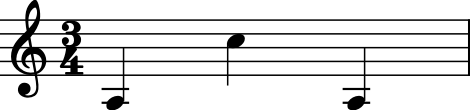

In [30]:
get_measure(p.pitches()).show()

C5 and A3 split by E4
C5 and E4 split by G4
C5 and G4 split by A4
C5 and A4 split by B4
G4 and E4 split by F4
E4 and A3 split by C4
E4 and C4 split by D4
C4 and A3 split by B3
 [ [A3 C5]   [ [ [ [ [C5 B4]   [B4 A4] ]   [A4 G4] ]   [ [G4 F4]   [F4 E4] ] ]   [ [ [E4 D4]   [D4 C4] ]   [ [C4 B3]   [B3 A3] ] ] ] ] 


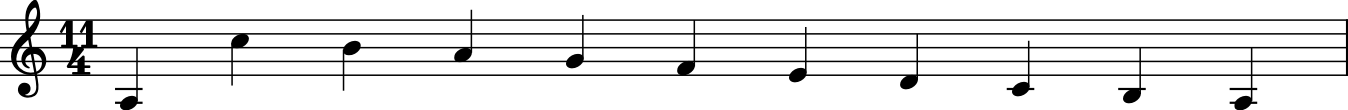

In [31]:
def get_middle(scale, start, end):
    pitches = scale.getPitches(start, end)
    middle = len(pitches) // 2
    return pitches[middle]

class skip(pair):
    
    def apply_rule(self):
        if isinstance(self.l, pitch.Pitch):
            iv = interval.Interval(self.l, self.r)
            if iv.direction == -1 and abs(iv.semitones) > 2: ## if descending and larger than a whole tone
                self.split()
                    
    def split(self):
        middle = get_middle(self.scale, self.l, self.r)
        print(f"{self.l} and {self.r} split by {middle}")
        self.l = skip(self.l, middle)
        self.r = skip(middle, self.r)
                
   
p = pair(pitch.Pitch('A3'))
print(p)
melody = get_measure(p.pitches())
melody.show()
play(melody)

A3 prepared by G#3
 [ [A3 C5]   [ [C5 G#3]   [G#3 A3] ] ] 


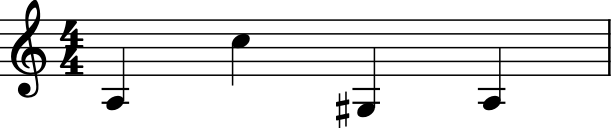

In [32]:
class skip(pair):
    
    def apply_rule(self):
        if isinstance(self.l, pitch.Pitch):
            iv = interval.Interval(self.l, self.r)
            if iv.direction == -1 and abs(iv.semitones) > 2:
                coin_toss = random.random() >= 0.2  ## is True 80 % of the time
                if coin_toss:
                    self.split()
                else:
                    self.prepare()
                    
    def split(self):
        middle = get_middle(self.scale, self.l, self.r)
        print(f"{self.l} and {self.r} split by {middle}")
        self.l = skip(self.l, middle)
        self.r = skip(middle, self.r)
        
    def prepare(self):
        leading_tone = self.r.transpose('-m2')
        print(f"{self.r} prepared by {leading_tone}")
        self.l = pair(self.l, leading_tone)
        self.r = pair(leading_tone, self.r)
                
   
p = pair(pitch.Pitch('A3'))
print(p)
melody = get_measure(p.pitches())
melody.show()
play(melody)

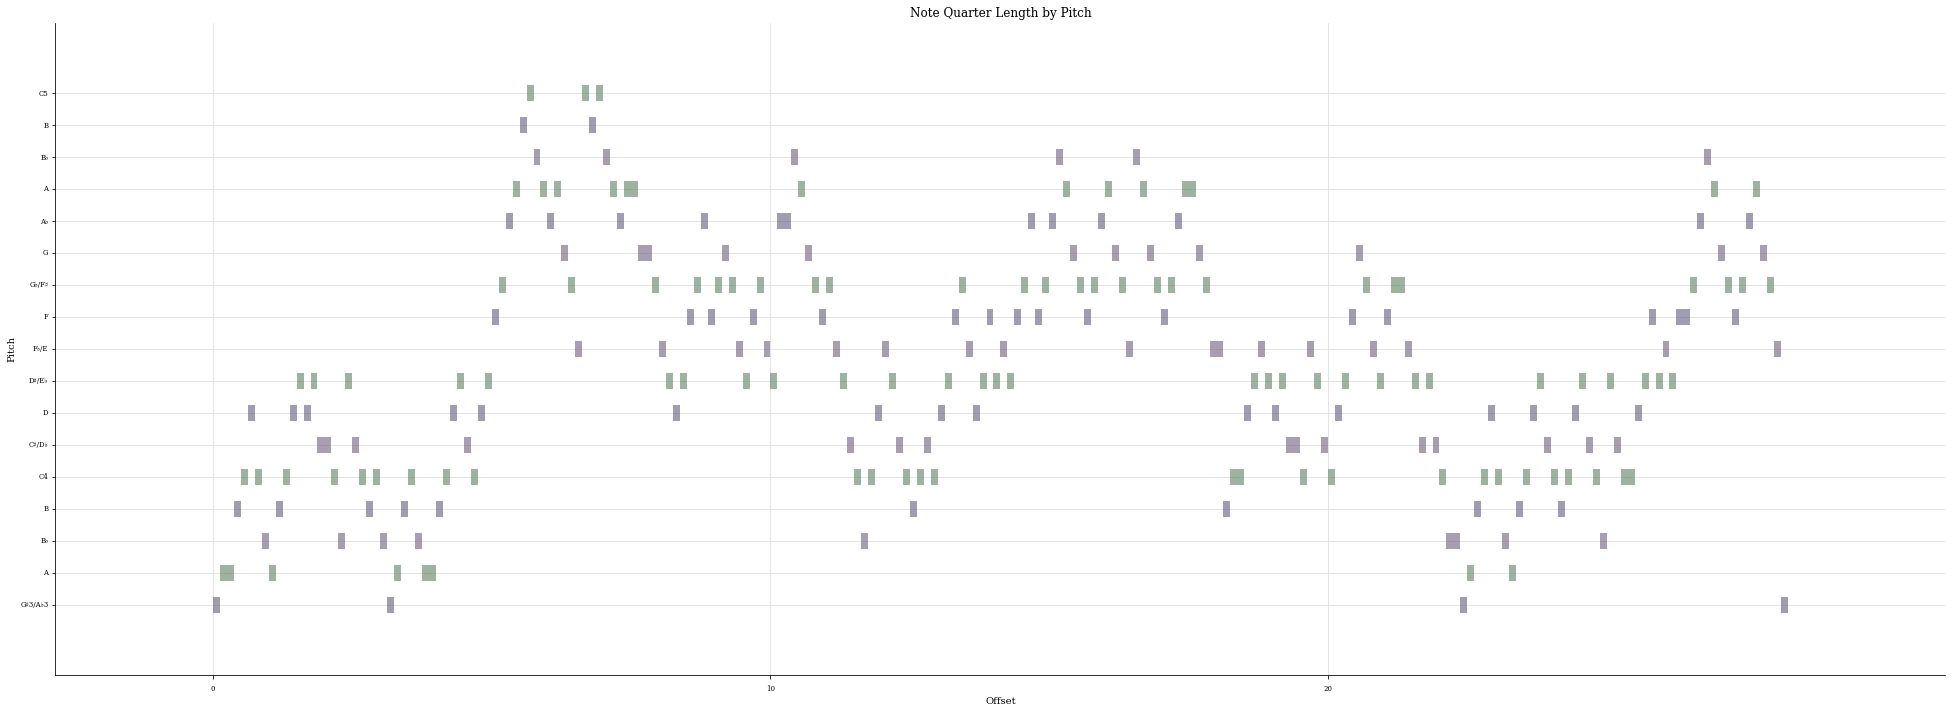

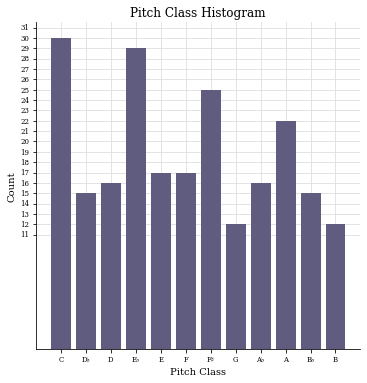

In [33]:
LOG = False
SPLIT_LARGER_THAN = 6
#SCALE_TYPE = scale.WholeToneScale
#SCALE_TYPE = scale.ChromaticScale
SCALE_TYPE = scale.OctatonicScale

def fill_iv(zig, zag):
    """ Takes two pitches and fills the interval between them with notes from
        two different scales, depending on the interval's direction.
    """
    if zig == zag:
        return [zig]
    direction2scale = {
        1: SCALE_TYPE('C'),
        -1: SCALE_TYPE('C#')
    }
    iv = interval.Interval(zig, zag)
    sc = direction2scale[iv.direction]
    return sc.getPitches(zig, zag)


def split_iv(zig, zag):
    """ Takes two pitches, calls fill_iv() and returns 3 randomly selected split points
        for creating two spike starting from the middle one.
    """
    pitches = fill_iv(zig, zag)
    n = len(pitches)
    splitpoint = random.randint(1, n-2)
    splits = {
        0: splitpoint,
        1: random.randint(0, splitpoint),
        2: random.randint(splitpoint, n-1)
    }
    return [pitches[splits[i]] for i in range(3)]


class zigzag:
    
    def __init__(self, zig, zag, comeback=True):
        self.zig, self.zag = zig, zag
        self.comeback = comeback
        self.iv = interval.Interval(zig, zag)
        self.zigzags = None                    ## by convention, all properties are declared in the __init__ function,
        self.pitches = None                    ## even if they are used only later
        self.apply_rule()
        
    def apply_rule(self):
        if abs(self.iv.semitones) > SPLIT_LARGER_THAN:
            self.split()
        else:
            self.fill()
                
    def split(self):
        splitpoint, spike1, spike2 = split_iv(self.zig, self.zag)
        if LOG:
            print(f"{self.zig} {self.zag} -> {self.zig} - {splitpoint} - {spike1} - {splitpoint} - {spike2} - {splitpoint} - {self.zag}")
        self.zigzags = {
            0: zigzag(self.zig, splitpoint, comeback=False),
            1: zigzag(splitpoint, spike1),
            2: zigzag(splitpoint, spike2),
            3: zigzag(splitpoint, self.zag, comeback=False)
        }
        splitpoint, spike1, spike2 = split_iv(self.zag, self.zig)
        if LOG:
            print(f"{self.zag} {self.zig} -> {self.zag} - {splitpoint} - {spike1} - {splitpoint} - {spike2} - {splitpoint} - {self.zig}")
        self.zigzags.update({
            4: zigzag(self.zag, splitpoint, comeback=False),
            5: zigzag(splitpoint, spike1),
            6: zigzag(splitpoint, spike2),
            7: zigzag(splitpoint, self.zig, comeback=False)
        })
        
    def fill(self):
        if LOG:
            print(f"Filled {self.zig}-{self.zag}{' coming back' if self.comeback else ''}")
        self.pitches = fill_iv(self.zig, self.zag)
        if self.comeback:
            self.pitches += fill_iv(self.zag, self.zig)[1:]
                    
    def get(self):
        if self.pitches is None:
            return [pitch for pitches in (zz.get() for zz in self.zigzags.values()) for pitch in pitches[:-1]] + [self.zig]
        else:
            return self.pitches
        
    def __repr__(self):
        return f"zig: {self.zig}, zag: {self.zag}"
        
         
p1 = pitch.Pitch('G#3')
p2 = pitch.Pitch('C5')
zz = zigzag(p1, p2)
melody = get_measure(zz.get(), 1/8)
piano_roll = graph.plot.HorizontalBarPitchSpaceOffset(melody)
piano_roll.figureSize = (35,12)
piano_roll.run()
melody.plot('histogram', 'pitchClass')

In [34]:
play(melody)

# Polyphony

Up to this point, we have generated individual melodies. In a piece of music, melodies may interact with one another, for example by playing simultaneously. This results in polyphony. 

As a simple example, we can build canons by shifting a melody against itself. The parameters of the canon are the delay of the *comes*, i.e. how much later compared to the *dux* it starts, and its transposition w.r.t. the *dux*.

In [35]:
def canon_from_theme(theme, delay, transposition):
    "Generates a canon based on a theme, after setting the delay and the transposition of the comes"
    
    dux = stream.Part() #set dux part
    comes = stream.Part() #set comes part

    dux.append(theme.flat.notesAndRests) #asign notes and rests from the theme to the dux
    
    #transposed theme for the comes
    transposed_theme = [x.transpose(interval.ChromaticInterval(transposition)) for x in theme.flat.notes]
    
    #append transposed theme to the comes, after a rest of duration delay
    comes.append([note.Rest(quarterLength = delay)]+transposed_theme)

    #set the score for the canon
    canon = stream.Score()
    canon.append(comes) #populate the score with the comes
    canon.append(dux) #populate the score with the dux
    
    #assign different instruments to the two parts, to make them more distinguishable
    canon[0].insert(0, instrument.Violin())  
    canon[1].insert(0, instrument.Violoncello())
    

    return canon

If we use the full chromatic collection as our theme, the canon will sound for example like this:

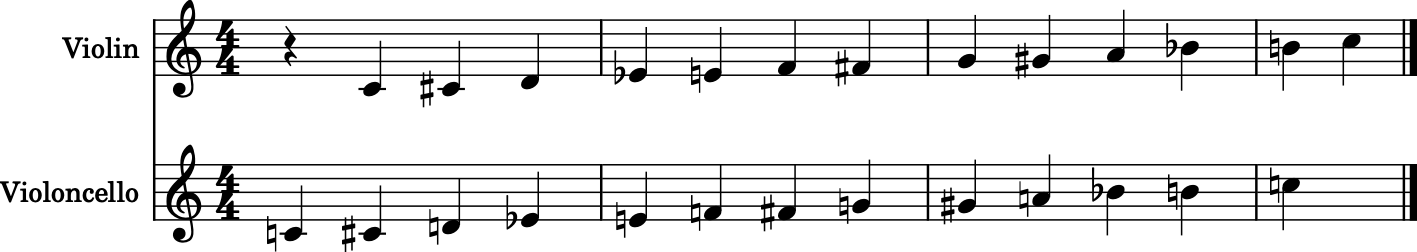

In [36]:
chromatic = stream.Stream()
chromatic.append([note.Note(pitch = x) for x in CHROMATIC])
chromatic_canon = canon_from_theme(chromatic, 1, 0)
chromatic_canon.show()
play(chromatic_canon)

Since we have different notes playing simultaneously, they form intervals with one another.

In [37]:
def get_simultaneity(score, offset):
    """Returns the list of simultaneous notes at a given offset"""
    notes = []
    for part in score.parts:
        notes += list(part.flat.getElementsByOffset(offset).notes)
    
    return notes 

def get_simultaneity_interval(score, offset):
    """returns the interval between simultaneous notes"""
    simultaneity = get_simultaneity(score, offset)
    return abs(interval.Interval(noteStart = simultaneity[0], noteEnd = simultaneity[1]).semitones)%12

    
def interval_histogram(score):
    """Counts the intervals formed between simultaneous notes across the score"""
    harmonic_intervals = []
    for offset in set([x.offset for x in score.flat.elements]):
        simultaneity = get_simultaneity(score, offset)
        if len(simultaneity)>1:
            harmonic_intervals += [get_simultaneity_interval(score, offset)]
    harmonic_intervals.sort()        
    return(Counter(harmonic_intervals))

In [38]:
interval_histogram(chromatic_canon)

Counter({1: 12})

Since the theme only comprises one type of (horizontal) interval, the semitone, also the vertical intervals that are formed between simultaneous notes in the *dux* and the *comes* are all equal. We can change the interval by choosing a different delay or transposition for the comes, but it will always be only one interval. If we choose a more varied theme, we also get more varied simultaneities:

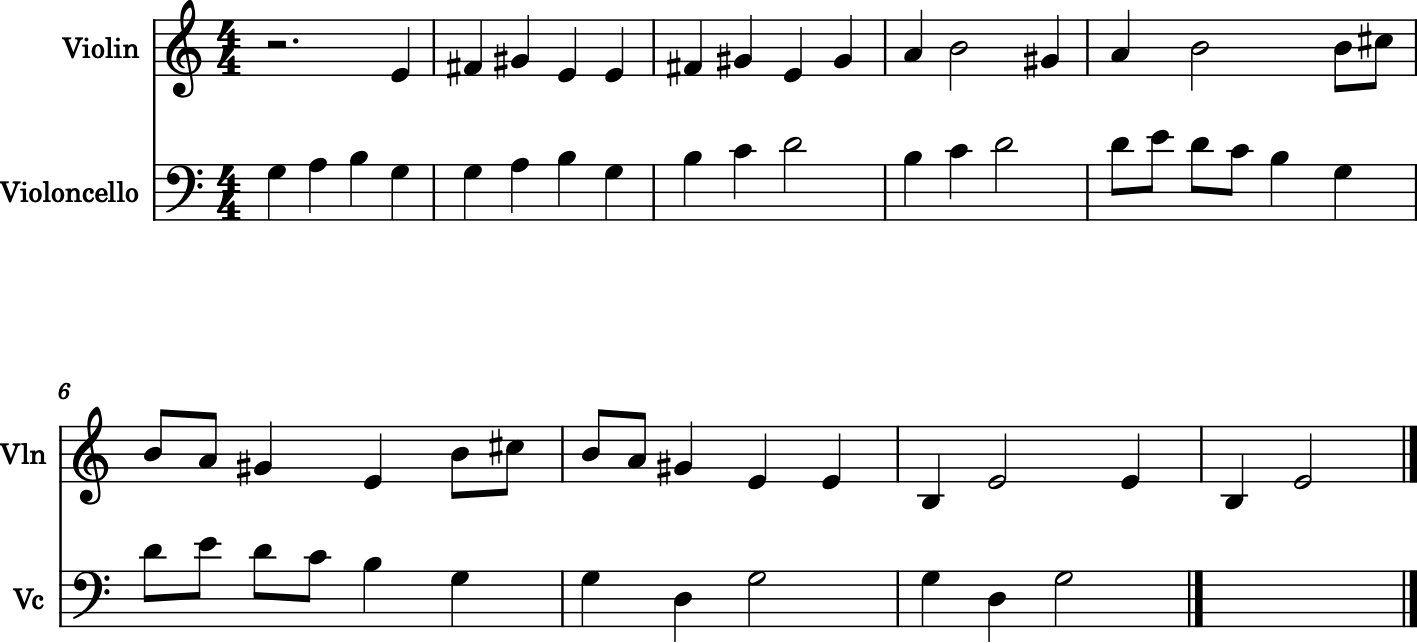

In [39]:
subject = converter.parse('frere_jacques.mid')
canon3 = canon_from_theme(subject, 3, 9)
canon3.show()

In [40]:
play(canon3)

In [41]:
interval_histogram(canon3)

Counter({2: 2, 4: 4, 5: 3, 6: 2, 7: 2, 8: 1, 9: 5, 10: 1, 11: 3})

Note how many different intervals are formed between simultaneous notes. In particular, there are many dissonant ones (1, 2, 10, or 11 semitones). If we choose a different delay and transposition, we can change the intervals that are formed, as well as the overall sonority:

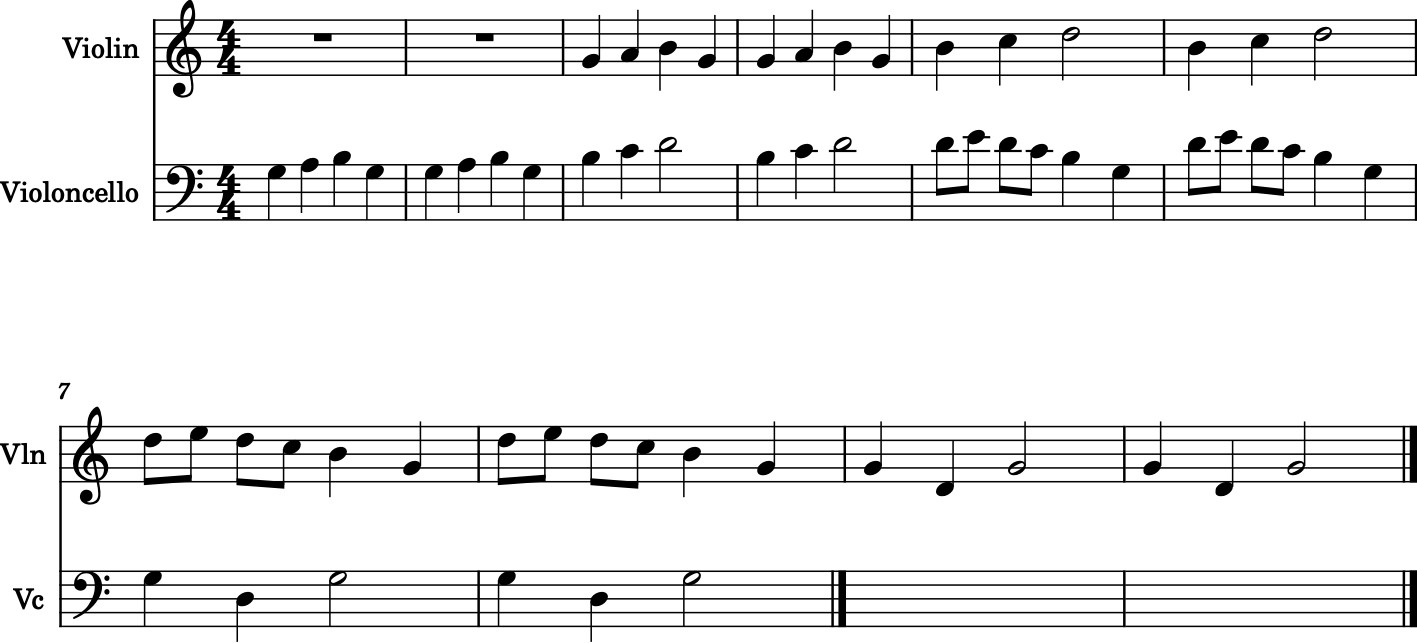

In [42]:
canon8 = canon_from_theme(subject, 8, 12)
canon8.show()

In [43]:
play(canon8)

In [ ]:
interval_histogram(canon8)